<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Предварительный-вывод:-данные" data-toc-modified-id="Предварительный-вывод:-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительный вывод: данные</a></span></li><li><span><a href="#Предварительный-вывод:-признаки-и-баланс-классов" data-toc-modified-id="Предварительный-вывод:-признаки-и-баланс-классов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предварительный вывод: признаки и баланс классов</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-модели-без-учёта-дисбаланса" data-toc-modified-id="Обучение-модели-без-учёта-дисбаланса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение модели без учёта дисбаланса</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Предварительный-вывод" data-toc-modified-id="Предварительный-вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Предварительный вывод</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Балансировка-целевого-признака:-параметр-class_weight" data-toc-modified-id="Балансировка-целевого-признака:-параметр-class_weight-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Балансировка целевого признака: параметр <code>class_weight</code></a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Предварительный-вывод" data-toc-modified-id="Предварительный-вывод-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Предварительный вывод</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Предварительный-вывод" data-toc-modified-id="Предварительный-вывод-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Предварительный вывод</a></span></li></ul></li><li><span><a href="#Балансировка-целевого-признака:-апсемплинг" data-toc-modified-id="Балансировка-целевого-признака:-апсемплинг-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Балансировка целевого признака: апсемплинг</a></span><ul class="toc-item"><li><span><a href="#Предварительный-вывод" data-toc-modified-id="Предварительный-вывод-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Предварительный вывод</a></span></li></ul></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li><li><span><a href="#Финальные-комментарии-ревьюера" data-toc-modified-id="Финальные-комментарии-ревьюера-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Финальные комментарии ревьюера</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Будет строиться модель с предельно большим значением *F1*-меры, необходимо довести метрику до значения **0.59**. Дополнительно производится замер метрики *AUC-ROC* и сравнение её с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

# сохраним значение random_state в переменную
rst = 48151623

# предупреждение CopyWithWarning
pd.options.mode.chained_assignment = None

# снимем ограничение на максимальное количество столбцов
pd.set_option('display.max_columns', None)

In [2]:
# откроем датасет
df = pd.read_csv('./datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()
df.describe().style.format("{:.2f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [4]:
# хочу проверить значения признаков и количество классов
for row in ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']:
    display(df[row].value_counts())
print(f"""
Пропусков в столбце Tenure: {df['Tenure'].isna().sum()}, доля пропусков составляет {df['Tenure'].isna().sum() / df.shape[0]}
Доля положительных классов в столбце Exited: {df['Exited'].sum() / df.shape[0]}
""")

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Male      5457
Female    4543
Name: Gender, dtype: int64

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

1    7055
0    2945
Name: HasCrCard, dtype: int64

1    5151
0    4849
Name: IsActiveMember, dtype: int64

0    7963
1    2037
Name: Exited, dtype: int64


Пропусков в столбце Tenure: 909, доля пропусков составляет 0.0909
Доля положительных классов в столбце Exited: 0.2037



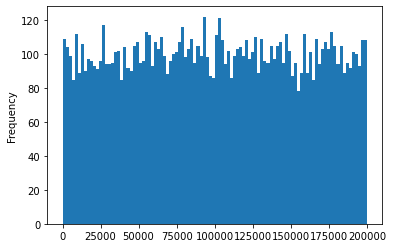

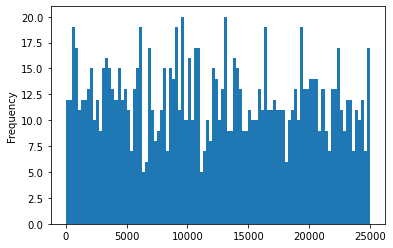

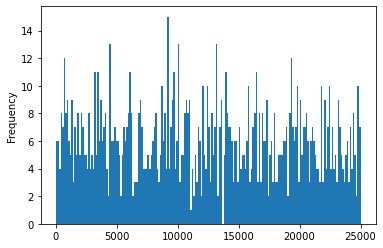

In [5]:
# изучим подробнее оценку зарплаты
df['EstimatedSalary'].plot(kind='hist', bins=100)
plt.show()
df.query('EstimatedSalary <= 25000')['EstimatedSalary'].plot(kind='hist', bins=100)
plt.show()
df.query('EstimatedSalary <= 25000')['EstimatedSalary'].plot(kind='hist', bins=200)
plt.show()

В столбце `EstimatedSalary` много странных, слишком низких значений. Не знаю, что с ними делать. Выясним, есть ли в данных выбросы

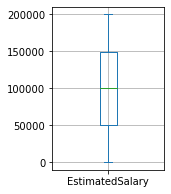

In [6]:
# проверим данные на наличие выбросов
df['EstimatedSalary'].plot(kind='box', figsize=(2, 3), grid=True)
plt.show()

В столбце с оценкой зарплаты выбросов не обнаружено.

Проанализируем распределение данных в столбце `Tenure`, чтобы понять, как лучше заполнить пропуски: средним значением или медианным.

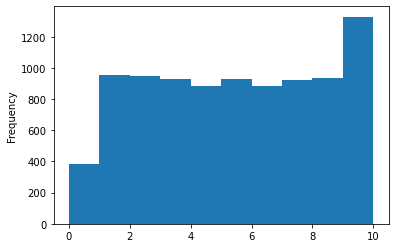

In [7]:
df['Tenure'].plot(kind='hist', bins=10)
plt.show()

### Предварительный вывод: данные

* нужно сделать столбец `RowNumber` индексом
* в столбце `Tenure` присутствуют и нули, и пропуски; пропуски нельзя оставлять, их нужно заполнить
* * в распределении данных нет выраженного среднего, зато присутствует пик в правой части; в этом случае характерным значением для заполнения будет **медиана**
* значения стобца `EstimatedSalary` равномерно распределены по всему диапазону; присутствуют низкие и высокие значения, которые достаточно распространены, чтобы не являться выбросами, а гистограммы распределений не имеют пика
* * скорее всего, значения в столбце `EstimatedSalary` являются предсказанными другой моделью
* * это, конечно, очевидно из заголовка, но проверить оценку всё равно стоит, поскольку эти данные будут влиять на обучение модели, в зависимости от того, будут ли они включены в качестве признака
* * будем считать *оценку* не связанной с реальными доходами, а некоторым параметром, определяющим величину доходов
* * другая причина равномерного распределения доходов может быть связана с тем, что имеющаяся в распоряжении выборка стратифицирована таким образом, чтобы в ней содержалось равное количество клиентов разного уровня дохода
* * * на это намекает третья гистограмма: при увеличенном количестве корзин видно, что общее распределение на самом деле состоит из множества пересекающихся нормальных распределений с локальными пиками в каждой группе
* * в реальной работе я бы попытался определить источник этих данных для принятия окончательного решения

### Предварительный вывод: признаки и баланс классов
* признаки `CustomerID` и `Surname` будут исключены из обучения, потому что не являются каким-то категориальным или числовым выражением финансовой активности человека
* категориальные признаки `Geography` и `Gender` должны быть разбиты по принципу OHE
* * признаки `HasCrCard`, `IsActiveMember`, `Exited` хоть и выражены числом, но являются категориями
* численные признаки `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary` требуют нормализации или применения весовых коэффициентов, поскольку сильно различаются порядками величин
* в столбце с целевым признаком `Exited` положительный класс составляет пятую часть от общего количества классов, что может являться существенным дисбалансом

In [8]:
# сделаем столбец RowNumber индексом
df = df.set_index(keys='RowNumber')
df.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


Заполним пропуски медианным значением

In [9]:
# заполним пропуски
# df['Tenure'] = df['Tenure'].fillna(df['Tenure'].mean())
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Так как по условию задачи нужно проанализировать два подхода к построению модели, разделять выборки будем для каждого случая отдельно

## Исследование задачи

### Подготовка признаков

Отбросим столбцы `CustomerId` и `Surname`, разобьём признаки `Geography` и `Gender` по принципу OHE.

In [10]:
df2 = pd.get_dummies(df.drop(columns=['CustomerId', 'Surname']), drop_first=True)
df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [11]:
# выделим признаки
X = df2.drop(columns=['Exited'])
# выделим целевой признак
y = df2['Exited']
print(X.shape, y.shape)

(10000, 11) (10000,)


Сделаем небольшую функцию для оценки сразу пяти метрик: на вход поступают модель, признаки и целевой признак, возвращается строка датафрейма, которую, можно присоединять в циклах.

In [12]:
# функция для оценки метрик
def all_metrics(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    return pd.DataFrame([[accuracy_score(y_val, y_pred),
                          recall_score(y_val, y_pred),
                          precision_score(y_val, y_pred),
                          f1_score(y_val, y_pred),
                          roc_auc_score(y_val, y_proba[:, 1])]],
                        columns=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'])

### Обучение модели без учёта дисбаланса

Обучим модель без учёта дисбаланса классов и определим значение метрик, чтобы оценить влияние этого дисбаланса на результат. Для проведения оценки будем использовать **логистическую регрессию** и **дерево решений**. В качестве солвера для логистической регрессии будем использовать `liblinear`, так как он лучше подходит для сравнительно небольших датасетов, при этом не так чувствителен к дисбалансу классов. Остальные параметры оставим без изменений.

Отложим пятую часть данных для использования в качестве тестовой выборки

In [13]:
# разбиваем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rst)
print(f"""
Размер обучающей выборки: {X_train.shape}, {y_train.shape}
Размер тестовой выборки: {X_test.shape}, {y_test.shape}
""")


Размер обучающей выборки: (8000, 11), (8000,)
Размер тестовой выборки: (2000, 11), (2000,)



In [14]:
# подготовим список числовых признаков
num_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [15]:
# создаим скейлер и фитанём все числовые признаки тренировочной выборки
scaler = StandardScaler().fit(X_train[num_list])

In [16]:
# используем скейлер для трансформации признаков выборок
X_train[num_list] = scaler.transform(X_train[num_list])
# X_val[num_list] = scaler.transform(X_val[num_list])
X_test[num_list] = scaler.transform(X_test[num_list])
X_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
17,0.025110,1.794031,-1.447328,0.896437,-0.907235,1,0,-1.650202,1,0,1
6502,0.295713,-0.838564,1.451223,-1.230680,0.808575,1,0,1.000012,0,0,1
3062,-0.693028,-0.556500,-0.722690,0.185947,0.808575,1,1,1.343139,1,0,1


#### Дерево решений

In [17]:
# для построения таблицы без лишних столбцов
m = 'mean_test_'
r = 'rank_test_'
metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

In [18]:
# переберём максимальную глубину дерева решений и определим метрики
model_dt = DecisionTreeClassifier(random_state=rst)
param_dict = {'max_depth': list(range(2, 20))}

clf_dt = GridSearchCV(
    model_dt,
    param_dict,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1'
)

clf_dt.fit(X_train, y_train)
df_model_dt = pd.DataFrame(clf_dt.cv_results_)[['param_max_depth'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_dt.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_max_depth,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
4,6,0.857250,0.455753,0.751940,0.565983,0.828599,1,14,3,1,1
5,7,0.852375,0.458208,0.720152,0.559564,0.825132,3,13,5,2,3
6,8,0.848750,0.463702,0.697221,0.556690,0.811778,4,11,6,3,4
3,5,0.852625,0.452724,0.728674,0.555207,0.825369,2,15,4,4,2
8,10,0.834125,0.480193,0.624465,0.542456,0.764966,8,8,9,5,8


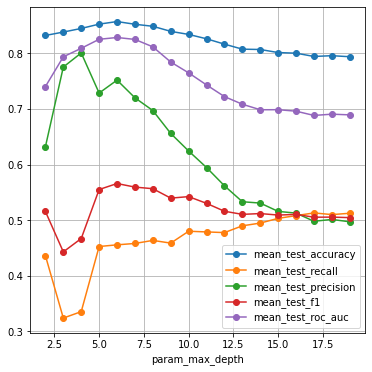

In [19]:
# построим графики
df_model_dt[['param_max_depth'] + [m + i for i in metrics]].plot(x='param_max_depth', grid=True, style='-o', figsize=(6, 6))
plt.show()

In [20]:
# проверим лучшую модель на тестовой выборке
all_metrics(clf_dt.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.852,0.38191,0.752475,0.506667,0.83734


#### Логистическая регрессия

In [21]:
# построим логистическую регрессию и определим метрики на тестовой выборке
model_lr = LogisticRegression(random_state=rst).fit(X_train, y_train)
all_metrics(model_lr, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8095,0.203518,0.558621,0.298343,0.765599


### Предварительный вывод

* ни решающим деревом, ни логистической регрессией не удалось достичь удовлетворительного значения **F1-score**
* **F1-score** логистической регресси намного ниже такового у решающего дерева: чувствительность логистической регрессии к дисбалансу классов намного выше, чем у решающего дерева
* метрик **ROC_AUC** в обоих случаях довольно высокая, так как она нечувствительна к дисбалансу классов
* необходимо исправить дисбаланс классов целевого признака

## Борьба с дисбалансом

### Балансировка целевого признака: параметр `class_weight`

Для борьбы с дисбалансом классов целевого признака воспользуемся параметром `class_weight` при использовании моделей

#### Решающее дерево

Как и в предыдущем пункте, построим модели **решающего дерева** и **логистической регрессии**, добавив `class_weight = 'balanced'`

In [22]:
# переберём максимальную глубину дерева решений и определим метрики
model_dt_balanced = DecisionTreeClassifier(random_state=rst, class_weight='balanced')
param_dict = {'max_depth': list(range(2, 20))}

clf_dt_balanced = GridSearchCV(
    model_dt_balanced,
    param_dict,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1'
)

clf_dt_balanced.fit(X_train, y_train)
df_model_dt_balanced = pd.DataFrame(clf_dt_balanced.cv_results_)[['param_max_depth'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_dt_balanced.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_max_depth,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
4,6,0.77750,0.735207,0.472485,0.575206,0.832102,12,3,13,1,1
5,7,0.78400,0.708975,0.482783,0.573982,0.826703,9,4,7,2,3
3,5,0.75600,0.773048,0.445743,0.564915,0.830707,15,1,15,3,2
6,8,0.77975,0.692511,0.474816,0.563105,0.800725,10,5,10,4,5
7,9,0.77725,0.674797,0.473473,0.554998,0.778896,13,8,11,5,7


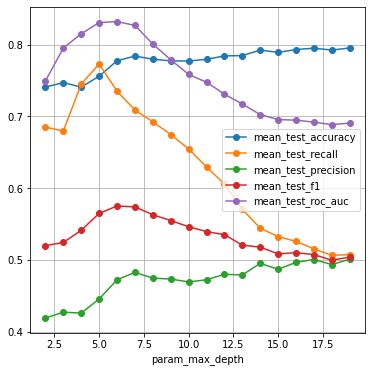

In [23]:
# построим графики
df_model_dt_balanced[['param_max_depth'] + [m + i for i in metrics]].plot(x='param_max_depth', grid=True, style='-o', figsize=(6, 6))
plt.show()

In [24]:
# проверим лучшую модель на тестовой выборке
all_metrics(clf_dt_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.7895,0.758794,0.481659,0.589268,0.844531


In [25]:
# для сравнения метрики лучшей модели без учёта дисбаланса
all_metrics(clf_dt.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.852,0.38191,0.752475,0.506667,0.83734


#### Логистическая регрессия

In [26]:
# построим логистическую регрессию и определим метрики на тестовой выборке
model_lr_balanced = LogisticRegression(random_state=rst, class_weight='balanced').fit(X_train, y_train)
all_metrics(model_lr_balanced, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.7015,0.688442,0.366801,0.478603,0.769569


In [27]:
# для сравнения метрики логистической регрессии до устранения дисбаланса
all_metrics(model_lr, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8095,0.203518,0.558621,0.298343,0.765599


#### Предварительный вывод
* результаты лучше, чем были без дисбаланса классов но **f1-мера** по-прежнему недостаточно высокая
* значительно выросла **полнота** - на эту метрику оказывало сильное влияние небольшое количество положительных классов целевого признака; в модели со сбалансированным целевым признаком вес положительных классов увеличился
* метрика **roc-auc** практически не изменилась
* воспользуемся моделью **случайного леса** и найдём гиперпаметры, и попробуем добиться нужного значения **f1-меры**

#### Случайный лес

Подберём гиперпараметры, используя `GridSearchCV`

In [28]:
# переберём количество деревьев и максимальную глубину
model_rf_balanced = RandomForestClassifier(random_state=rst, class_weight='balanced')
param_dict_rf = {'n_estimators': list(range(45, 55)),
                 'max_depth': list(range(7, 12))}

clf_rf_balanced = GridSearchCV(
    model_rf_balanced,
    param_dict_rf,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'], 
    verbose=1,
    refit='f1'
)

clf_rf_balanced.fit(X_train, y_train)
df_model_rf_balanced = pd.DataFrame(clf_rf_balanced.cv_results_)[['param_max_depth', 'param_n_estimators'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_rf_balanced.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,param_max_depth,param_n_estimators,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
21,9,46,0.839250,0.646120,0.601186,0.622477,0.859165,22,21,22,1,9
39,10,54,0.845750,0.619887,0.625197,0.622358,0.855954,11,31,11,2,31
23,9,48,0.839250,0.644898,0.600968,0.621921,0.859608,22,22,24,3,7
26,9,51,0.839875,0.641848,0.603097,0.621693,0.859972,21,27,21,4,1
20,9,45,0.838750,0.643681,0.600129,0.620841,0.859159,26,23,26,5,10


In [29]:
# проверим лучшую модель на тестовой выборке
all_metrics(clf_rf_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8245,0.663317,0.548857,0.600683,0.857455


#### Предварительный вывод
* найдены параметры, при которых значение **f1-меры** удовлетворяет условию задачи, но это значение очень близко к 0.59
* значение **roc-auc** лучшей модели ~~также стало выше, но при наивысшем **f1 score** средний **roc-auc** не самый наивысший из возможных~~ немногим выше, чем таковой у решающего дерева
* посмотрим, можно ли увеличить метрику **f1-score**, увеличив количесво положительных классов

### Балансировка целевого признака: апсемплинг

План действий такой:
* определим, во сколько отрицательный класс превышает положительный
* выполним апсэмплинг тренировочной выборки по положительному классу, чтобы достичь одинакового количества классов
* * будет использоваться модель **случайного леса** и **решающего дерева**
* перемешаем тренировочную выборку
* подберём гиперпараметры для модели случайного леса с помощью `GridSearchCV`

In [30]:
# во сколько раз отрицательный класс превышает положительный
y[y == 0].shape[0] / y[y == 1].shape[0]

3.9091801669121256

In [31]:
# функция для апсемпла положительных классов
def upsample(X, y):
    X_0 = X[y == 0]
    X_1 = X[y == 1]
    y_0 = y[y == 0]
    y_1 = y[y == 1]
    repeat = X_0.shape[0] // X_1.shape[0] + 1
    X_upsampled = pd.concat([X_0] + [X_1] * repeat)
    y_upsampled = pd.concat([y_0] + [y_1] * repeat)
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=rst)
    return X_upsampled, y_upsampled

In [32]:
# применим функцию для апсемплинга
X_train_up, y_train_up = upsample(X_train, y_train)
print(X_train_up.shape, y_train_up.shape)
print(y_train_up.value_counts())

(12917, 11) (12917,)
1    6556
0    6361
Name: Exited, dtype: int64


In [33]:
X_train_up.var()

CreditScore          1.034374
Age                  1.023824
Tenure               1.017570
Balance              0.971060
NumOfProducts        1.346440
HasCrCard            0.207625
IsActiveMember       0.247986
EstimatedSalary      1.005223
Geography_Germany    0.211577
Geography_Spain      0.178449
Gender_Male          0.249919
dtype: float64

#### Случайный лес

Воспользуемся `GridSearchCV` для поиска гиперпараметров

In [34]:
# переберём количество деревьев и максимальную глубину
model_rf_up = RandomForestClassifier(random_state=rst)
param_dict_up = {'n_estimators': list(range(45, 55)),
                 'max_depth': list(range(7, 12))}

clf_rf_up = GridSearchCV(
    model_rf_up,
    param_dict_up,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1',
    cv=5
)

clf_rf_up.fit(X_train_up, y_train_up)
df_model_rf_up = pd.DataFrame(clf_rf_up.cv_results_)[['param_max_depth', 'param_n_estimators'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_rf_up.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,param_max_depth,param_n_estimators,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
47,11,52,0.880544,0.898109,0.870746,0.884179,0.952003,3,3,4,1,1
46,11,51,0.880544,0.898109,0.870739,0.884176,0.951867,2,4,5,2,2
49,11,54,0.880622,0.897346,0.871378,0.884149,0.951583,1,7,1,3,9
40,11,45,0.880467,0.898261,0.870471,0.884126,0.951523,4,2,6,4,10
42,11,47,0.880312,0.898262,0.870197,0.883988,0.951639,5,1,10,5,7


In [35]:
# проверим лучшую модель на тестовой выборке
all_metrics(clf_rf_up.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8255,0.678392,0.549898,0.607424,0.857242


In [36]:
# для сравнения лучшая модель без апскейла классов но со сбалансированными весовыми коэффициентами
all_metrics(clf_rf_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8245,0.663317,0.548857,0.600683,0.857455


#### Решающее дерево

Воспользуемся `GridSearchCV` для поиска гиперпараметров

In [37]:
# переберём максимальную глубину дерева решений и определим метрики
model_dt_up = DecisionTreeClassifier(random_state=rst)
param_dict_up = {'max_depth': list(range(2, 20))}

clf_dt_up = GridSearchCV(
    model_dt_up,
    param_dict_up,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1'
)

clf_dt_up.fit(X_train_up, y_train_up)
df_model_dt_up = pd.DataFrame(clf_dt_up.cv_results_)[['param_max_depth'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_dt_up.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_max_depth,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
17,19,0.921963,0.991764,0.872177,0.928105,0.923794,1,1,1,1,2
16,18,0.918325,0.989629,0.868058,0.924838,0.922013,2,2,3,2,5
15,17,0.916853,0.984137,0.869364,0.923180,0.924236,3,3,2,3,1
14,16,0.911047,0.981239,0.862493,0.918031,0.923624,4,4,4,4,3
13,15,0.900595,0.964307,0.857669,0.907844,0.923513,5,5,5,5,4


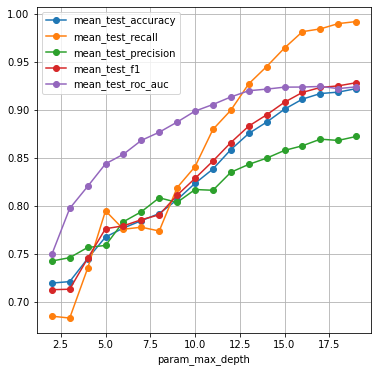

In [38]:
# построим графики
df_model_dt_up[['param_max_depth'] + [m + i for i in metrics]].plot(x='param_max_depth', grid=True, style='-o', figsize=(6, 6))
plt.show()

In [39]:
# проверим лучшую модель на тестовой выборке
all_metrics(clf_dt_up.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.7885,0.494975,0.470167,0.482252,0.677754


In [40]:
# для сравнения лучшая модель без апскейла классов но со сбалансированными весовыми коэффициентами
all_metrics(clf_dt_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.7895,0.758794,0.481659,0.589268,0.844531


#### Предварительный вывод
* значения метрик на тестовой выборке для **случайного леса** при использовании апскейлинга дали почти такие же результаты, как при использовании сбалансированных весовых коэффициентов
* * в полученной модели с наивысшим значением **f1-score** наивысшее значение **roc-auc**
* * лучшая по метрике **f1-score** модель была сохранена в объекте `clf_rf_up` в атрибуте `.best_estimator_`
* модель **решающего дерева** переобучается и плохо показывает себя на тестовой выборке

## Вывод

* лучшая модель случайного леса обеспечила следующие значения метрик:

In [41]:
all_metrics(clf_rf_up.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8255,0.678392,0.549898,0.607424,0.857242


* при подготовке данных выполнены следующие действия:
* * пропуски столбца `Tenure` заполнены медианным значением
* * столбцы `RowNumber`, `CustomerId` и `Surname` исключены из обучения
* * выполнено масштабирование численных признаков методом стандартизации
* * устранён дисбаланс классов
* меры, принятые по устранению дисбаланса классов, увеличивали на валидации не только **f1-score**, но и **auc-roc**
* * рост **auc-roc** при этом был не настолько драматичным, потому что эта метрика не так сильно зависит от дисбаланса классов
* * устранение дисбаланса классов позволило увеличить **полноту** модели
* использование кроссвалидации позволило увеличить количество данных, используемых для обучения
* в кейсе "Бета-Банка" метрика **recall** имеет больше значения, чем **precision**, поскольку важно охватить больше клиентов, которые потенциально могут покинуть банк
* * это также зависит от того, какие меры будут приниматься для удержания клиентов: если эти меры не изменят отношения клиентов, которых и так всё устраивает, но которые по ошибке попали в "группу риска", значение **precision** не так важно, как полнота